In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import math
import copy
import pyzx
from typing import List,Tuple
from pyzx.graph.base import BaseGraph, VT, ET
import math
import random
import time
import matplotlib.pyplot as plt
import pyzx
from pyzx.graph.base import BaseGraph
from typing import List, Tuple

In [ ]:
class SimulatedAnnealer:
    """
    Attributes:
        initial_temp (float): 初期温度
        final_temp (float): 最終温度
        cooling_rate (float): 冷却率 (0 < alpha < 1)
        max_iterations (int): 各温度での最大試行回数
    """
    def __init__(self, initial_temp, final_temp, cooling_rate, max_iterations):
        self.initial_temp = initial_temp
        self.final_temp = final_temp
        self.cooling_rate = cooling_rate
        self.max_iterations = max_iterations

    def _acceptance_probability(self, old_score, new_score, temp):
        if new_score < old_score:
            return 1.0
        if temp == 0:
            return 0.0
        delta_score = new_score - old_score
        return math.exp(-delta_score / temp)

    def solve(self, initial_state: BaseGraph, evaluate_func, get_neighbor_func):
        start_time = time.time()
        current_temp = self.initial_temp
        current_state = initial_state
        current_score = evaluate_func(current_state)

        best_state = current_state
        best_score = current_score

        # 実行時間と遷移回数を履歴に追加
        history = {'score': [], 'time': [], 'transition_count': []}
        transition_count = 0
        
        print(f"初期スコア: {best_score}")
        
        # 初期状態を履歴に追加
        history['score'].append(current_score)
        history['time'].append(0.0)
        history['transition_count'].append(transition_count)
        count = 0
        
        while current_temp > self.final_temp:
            for i in range(self.max_iterations):
                neighbor_list = get_neighbor_func(current_state)
                if not neighbor_list:
                    continue # 遷移先がなければ次の試行へ

                # 近傍からランダムに1つ選択
                neighbor_state, neighbor_score = random.choice(neighbor_list)

                # 遷移確率を計算
                prob = self._acceptance_probability(current_score, neighbor_score, current_temp)
                
                # 確率に基づいて遷移を決定
                if random.random() < prob:
                    current_state = neighbor_state
                    current_score = neighbor_score
                    
                    # 遷移が発生したので履歴を記録
                    transition_count += 1
                    elapsed_time = time.time() - start_time
                    history['score'].append(current_score)
                    history['time'].append(elapsed_time)
                    history['transition_count'].append(transition_count)

                    # 最良解を更新
                    if current_score < best_score:
                        best_state = current_state
                        best_score = current_score
                        print(f"  T={current_temp:.2f}, iter={}, 遷移回数={transition_count} -> 新しい最良スコア: {best_score}")

            # 温度を更新（冷却）
            current_temp *= self.cooling_rate
            print(f"温度更新: {current_temp:.2f}, 現在スコア: {current_score}, 最良スコア: {best_score}")

        return best_state, best_score, history

In [3]:
def generate_H_S_CNOT_T_circuit(qubits, gates, p_t=0, seed=1000):
    random.seed(seed)  
    p_s = 0.333 * (1.0 - p_t)  
    p_had = 0.333 * (1.0 - p_t)  
    p_cnot = 0.333 * (1.0 - p_t)  

    c = pyzx.Circuit(qubits) 
    for _ in range(gates):
        r = random.random() 
        if r < p_had:
            c.add_gate("HAD", random.randrange(qubits))
        elif r < p_had + p_s:
            c.add_gate("S", random.randrange(qubits))
        elif r < p_had + p_s + p_t:
            c.add_gate("T", random.randrange(qubits))
        else:
            tgt = random.randrange(qubits)
            while True:
                ctrl = random.randrange(qubits)
                if ctrl != tgt:
                    break
            c.add_gate("CNOT", tgt, ctrl)
    return c

In [ ]:

def get_actions(g:BaseGraph):
    lc = pyzx.rules.match_lcomp_parallel(g)
    pv = pyzx.rules.match_pivot_parallel(g)
    return lc,pv

def print_graph_data(g: BaseGraph):
    boundarycount= 0
    for v in g.vertices():

        if (g.type(v) == 0):
            vtype = "Boundary"
            boundarycount +=1
        else:
            vtype = "Z"

        phase = g.phase(v)
        neighbors = g.neighbors(v)
        print(f"Vertex {v}:")
        print(f"  Type: {vtype}")
        print(f"  Phase: {phase}")
        print(f"  Neighbors: {neighbors}")
    
    for e in g.edges():
        s, t = g.edge_st(e)
        etype = g.edge_type(e)
        print(f"Edge {e}: {s} --({etype})-- {t}")
    print("boudarycount",boundarycount)

def get_gate_num(g:BaseGraph):
    g_tmp = g.copy()
    c = pyzx.extract.extract_circuit(g_tmp,up_to_perm=True)
    c = pyzx.optimize.basic_optimization(c)
    a = c.stats_dict()
    dict = {}
    dict["all"] = a["gates"]
    dict["two"] = a["twoqubit"]
    dict["one"] = a["gates"] - a["twoqubit"]
    dict["t"] = a["tcount"]
    return dict

def get_node_and_edge_num(g:BaseGraph) -> Tuple[int, int]:
    a= g.num_vertices()
    b = g.num_edges()
    return a,b

def score(g:BaseGraph) -> int:
    a = get_gate_num(g)
    score = 10 * a["two"] + a["one"]
    return score

def get_neighbor_scores(g: BaseGraph) -> List[Tuple[BaseGraph, int]]:
    """
    現在のグラフ状態から遷移可能な全ての近傍状態を生成し、
    それぞれの状態とそのスコアのペアをリストとして返す。

    Args:
        g (BaseGraph): 現在のグラフ状態。

    Returns:
        List[Tuple[BaseGraph, int]]: (近傍のグラフ状態, そのスコア) のタプルで構成されるリスト。
    """
    # 適用可能な操作（lcompとpivot）のリストを取得

    #g.copyは、元の頂点番号を変化させる場合があるので、get_actionsとapply_rule対象のグラフは同じでなければならない
    g2 = g.copy()
    lcomp_matches, pivot_matches = get_actions(g2)
    
    neighbor_list = []

    # lcomp操作を適用した近傍を生成・評価
    for match in lcomp_matches:
        g_tmp = g2.copy()
        pyzx.rules.apply_rule(g_tmp, pyzx.rules.lcomp, [match], check_isolated_vertices=True)
        pyzx.simplify.id_simp(g_tmp,quiet=True)
        pyzx.simplify.spider_simp(g_tmp,quiet=True)
        neighbor_list.append((g_tmp, score(g_tmp)))


    # pivot操作を適用した近傍を生成・評価
    for match in pivot_matches:
        g_tmp = g.copy()
        pyzx.rules.apply_rule(g_tmp, pyzx.rules.pivot, [match], check_isolated_vertices=True)
        pyzx.simplify.id_simp(g_tmp,quiet=True)
        pyzx.simplify.spider_simp(g_tmp,quiet=True)
        neighbor_list.append((g_tmp, score(g_tmp)))

    return neighbor_list


def plot_graphs(history):
    """
    実行履歴から2種類のグラフを描画する。
    1. 横軸: 実行時間, 縦軸: 遷移回数
    2. 横軸: 遷移回数, 縦軸: スコア
    """
    if not history or len(history['transition_count']) <= 1:
        print("グラフを描画するのに十分な履歴がありません。")
        return

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # グラフ①: 横軸 実行時間, 縦軸 遷移回数
    ax1.plot(history['time'], history['transition_count'], marker='o', linestyle='-', markersize=3)
    ax1.set_xlabel("Execution Time (seconds)")
    ax1.set_ylabel("Number of Transitions")
    ax1.set_title("Transitions over Time")
    ax1.grid(True)

    # グラフ②: 横軸 遷移回数, 縦軸 スコア
    ax2.plot(history['transition_count'], history['score'], marker='o', linestyle='-', markersize=3)
    ax2.set_xlabel("Number of Transitions")
    ax2.set_ylabel("Score")
    ax2.set_title("Score per Transition")
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()


spider_simp: 89. 51. 33. 17. 6. 1.  6 iterations
id_simp: 2.  1 iterations
初期グラフが生成されました。

--- 焼きなまし法を開始 ---
初期スコア: 1628
  T=10.00, iter=0, 遷移回数=1 -> 新しい最良スコア: 1587
温度更新: 9.80, 現在スコア: 1587, 最良スコア: 1587
温度更新: 9.60, 現在スコア: 1587, 最良スコア: 1587
温度更新: 9.41, 現在スコア: 1587, 最良スコア: 1587
温度更新: 9.22, 現在スコア: 1587, 最良スコア: 1587
  T=9.22, iter=0, 遷移回数=3 -> 新しい最良スコア: 1551
温度更新: 9.04, 現在スコア: 1551, 最良スコア: 1551
温度更新: 8.86, 現在スコア: 1551, 最良スコア: 1551
温度更新: 8.68, 現在スコア: 1551, 最良スコア: 1551
  T=8.68, iter=0, 遷移回数=5 -> 新しい最良スコア: 1549
温度更新: 8.51, 現在スコア: 1549, 最良スコア: 1549
温度更新: 8.34, 現在スコア: 1549, 最良スコア: 1549
温度更新: 8.17, 現在スコア: 1549, 最良スコア: 1549
温度更新: 8.01, 現在スコア: 1549, 最良スコア: 1549
温度更新: 7.85, 現在スコア: 1549, 最良スコア: 1549
温度更新: 7.69, 現在スコア: 1550, 最良スコア: 1549
温度更新: 7.54, 現在スコア: 1550, 最良スコア: 1549
温度更新: 7.39, 現在スコア: 1550, 最良スコア: 1549
温度更新: 7.24, 現在スコア: 1550, 最良スコア: 1549
温度更新: 7.09, 現在スコア: 1550, 最良スコア: 1549
温度更新: 6.95, 現在スコア: 1550, 最良スコア: 1549
温度更新: 6.81, 現在スコア: 1562, 最良スコア: 1549
温度更新: 6.68, 現在スコア: 1562, 最良スコア: 1549
温度更新: 6.5


--- パフォーマンスグラフ ---


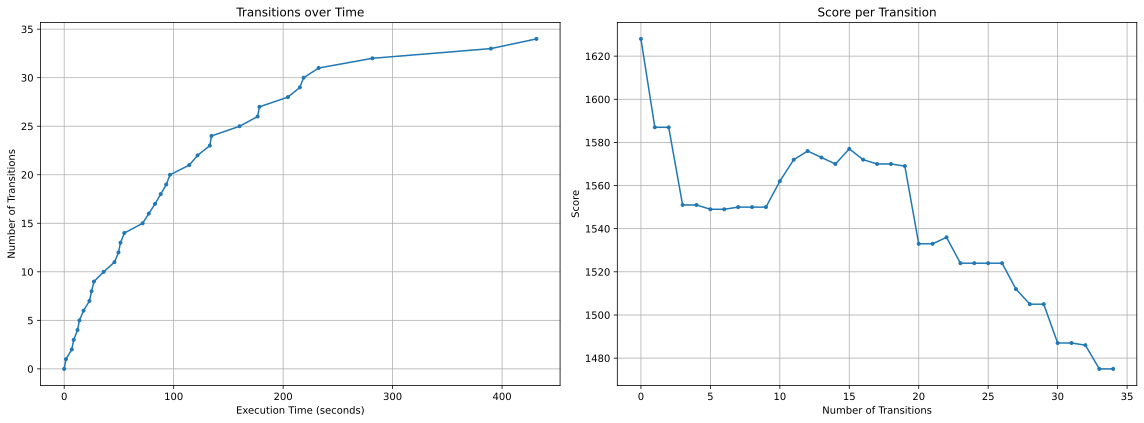

In [ ]:
# 1. 初期グラフの生成
c = generate_H_S_CNOT_T_circuit(8, 500, p_t=0.08, seed=1001) # depthを少し小さくして実行時間を調整
c = pyzx.optimize.basic_optimization(c)
initial_graph = c.to_graph()
pyzx.simplify.spider_simp(initial_graph)
pyzx.simplify.to_gh(initial_graph)
pyzx.simplify.id_simp(initial_graph)

print("初期グラフが生成されました。")
initial_score = score(initial_graph)

# 2. 焼きなまし法の設定と実行
print("\n--- 焼きなまし法を開始 ---")
sa = SimulatedAnnealer(
    initial_temp=10.0,
    final_temp=0.01,
    cooling_rate=0.98,
    max_iterations=1 # 各温度で10回試行
)

best_graph, best_score_result, score_history = sa.solve(
    initial_state=initial_graph,
    evaluate_func=score,
    get_neighbor_func=get_neighbor_scores
)

# 3. 結果の表示
print("\n--- 結果 ---")
print(f"初期スコア: {initial_score}")
print(f"最終的な最良スコア: {best_score_result}")

print("\n最適化後のグラフ:")
pyzx.draw(best_graph, labels=True)

# 4. 新しいグラフ描画関数を呼び出す
print("\n--- パフォーマンスグラフ ---")
plot_graphs(score_history)

In [13]:

c = generate_H_S_CNOT_T_circuit(8, 500, p_t=0.08, seed=1001) 
c = pyzx.optimize.basic_optimization(c)
print(c.stats())
g33 = c.to_graph()
pyzx.simplify.clifford_simp(g33)
print(score(g33))
print(get_gate_num(g33))

Circuit  on 8 qubits with 307 gates.
        31 is the T-count
        276 Cliffords among which
        147 2-qubit gates (113 CNOT, 34 other) and
        67 Hadamard gates.
1596
{'all': 237, 'two': 151, 'one': 86, 't': 31}


In [11]:
get_gate_num(best_graph)

{'all': 287, 'two': 132, 'one': 155, 't': 31}

In [20]:
import time
import math
import random

class SimulatedAnnealer2:
    """
    Attributes:
        initial_temp (float): 初期温度
        final_temp (float): 最終温度
        cooling_rate (float): 冷却率 (0 < alpha < 1)
    """
    def __init__(self, initial_temp, final_temp, cooling_rate):
        self.initial_temp = initial_temp
        self.final_temp = final_temp
        self.cooling_rate = cooling_rate

    def _acceptance_probability(self, old_score, new_score, temp):
        if new_score < old_score:
            return 1.0
        if temp == 0:
            return 0.0
        delta_score = new_score - old_score
        return math.exp(-delta_score / temp)

    def solve(self, initial_state, evaluate_func, get_neighbor_func):
        start_time = time.time()
        current_temp = self.initial_temp
        current_state = initial_state
        current_score = evaluate_func(current_state)

        best_state = current_state
        best_score = current_score

        # 履歴の初期化
        history = {
            'score': [current_score],
            'time': [0.0],
            'transition_count': [0],
            'iteration_count': [0]
        }

        transition_count = 0
        iteration_count = 0

        print(f"初期スコア: {best_score}")

        while current_temp > self.final_temp:
            neighbor_list = get_neighbor_func(current_state)
            iteration_count += 1

            if not neighbor_list:
                # 遷移先がなければ温度だけ下げて続行
                current_temp *= self.cooling_rate
                continue

            # 近傍からランダムに1つ選ぶ
            neighbor_state, neighbor_score = random.choice(neighbor_list)

            prob = self._acceptance_probability(current_score, neighbor_score, current_temp)

            if random.random() < prob:
                current_state = neighbor_state
                current_score = neighbor_score
                transition_count += 1

                elapsed_time = time.time() - start_time
                history['score'].append(current_score)
                history['time'].append(elapsed_time)
                history['transition_count'].append(transition_count)
                history['iteration_count'].append(iteration_count)

                if current_score < best_score:
                    best_state = current_state
                    best_score = current_score
                    print(f"  T={current_temp:.4f}, iter={iteration_count}, 遷移回数={transition_count} -> 新しい最良スコア: {best_score}")

            # 温度を冷却
            current_temp *= self.cooling_rate
            print(f"温度更新: {current_temp:.4f}, 現在スコア: {current_score}, 最良スコア: {best_score}")

        return best_state, best_score, history
    

def plot_graphs2(history):
    """
    実行履歴から2種類のグラフを描画する。
    1. 横軸: 実行時間, 縦軸: イテレーション回数
    2. 横軸: イテレーション回数, 縦軸: スコア
    """
    if not history or len(history['iteration_count']) <= 1:
        print("グラフを描画するのに十分な履歴がありません。")
        return

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # グラフ①: 横軸 実行時間, 縦軸 イテレーション回数
    ax1.plot(history['time'], history['iteration_count'], marker='o', linestyle='-', markersize=3)
    ax1.set_xlabel("Execution Time (seconds)")
    ax1.set_ylabel("Iteration Count")
    ax1.set_title("Iterations per Time")
    ax1.grid(True)

    # グラフ②: 横軸 イテレーション回数, 縦軸 スコア
    ax2.plot(history['iteration_count'], history['score'], marker='o', linestyle='-', markersize=3)
    ax2.set_xlabel("Iteration Count")
    ax2.set_ylabel("Score")
    ax2.set_title("Score per Iteration")
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

spider_simp: 89. 51. 33. 17. 6. 1.  6 iterations
id_simp: 2.  1 iterations
初期グラフが生成されました。

--- 焼きなまし法を開始 ---
初期スコア: 1628
  T=10.0000, iter=1, 遷移回数=1 -> 新しい最良スコア: 1587
温度更新: 9.8000, 現在スコア: 1587, 最良スコア: 1587
温度更新: 9.6040, 現在スコア: 1587, 最良スコア: 1587
温度更新: 9.4119, 現在スコア: 1587, 最良スコア: 1587
温度更新: 9.2237, 現在スコア: 1587, 最良スコア: 1587
  T=9.2237, iter=5, 遷移回数=3 -> 新しい最良スコア: 1551
温度更新: 9.0392, 現在スコア: 1551, 最良スコア: 1551
温度更新: 8.8584, 現在スコア: 1551, 最良スコア: 1551
温度更新: 8.6813, 現在スコア: 1551, 最良スコア: 1551
  T=8.6813, iter=8, 遷移回数=5 -> 新しい最良スコア: 1549
温度更新: 8.5076, 現在スコア: 1549, 最良スコア: 1549
温度更新: 8.3375, 現在スコア: 1549, 最良スコア: 1549
温度更新: 8.1707, 現在スコア: 1549, 最良スコア: 1549
温度更新: 8.0073, 現在スコア: 1549, 最良スコア: 1549
温度更新: 7.8472, 現在スコア: 1549, 最良スコア: 1549
温度更新: 7.6902, 現在スコア: 1550, 最良スコア: 1549
温度更新: 7.5364, 現在スコア: 1550, 最良スコア: 1549
温度更新: 7.3857, 現在スコア: 1550, 最良スコア: 1549
温度更新: 7.2380, 現在スコア: 1550, 最良スコア: 1549
温度更新: 7.0932, 現在スコア: 1550, 最良スコア: 1549
温度更新: 6.9514, 現在スコア: 1550, 最良スコア: 1549
温度更新: 6.8123, 現在スコア: 1562, 最良スコア: 1549
温度


--- パフォーマンスグラフ ---


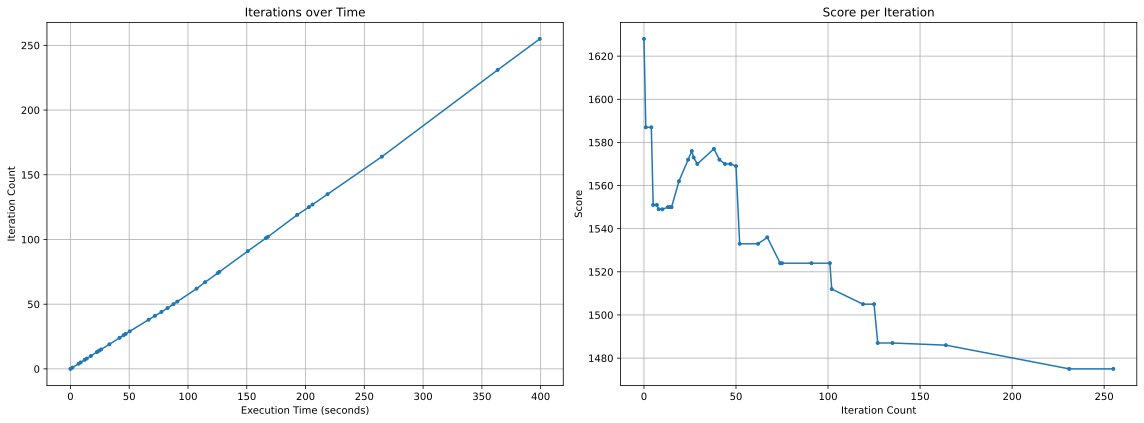

In [ ]:
# 1. 初期グラフの生成
c = generate_H_S_CNOT_T_circuit(8, 500, p_t=0.08, seed=1002) # depthを少し小さくして実行時間を調整
c = pyzx.optimize.basic_optimization(c)
initial_graph = c.to_graph()
pyzx.simplify.spider_simp(initial_graph)
pyzx.simplify.to_gh(initial_graph)
pyzx.simplify.id_simp(initial_graph)

print("初期グラフが生成されました。")
initial_score = score(initial_graph)

# 2. 焼きなまし法の設定と実行
print("\n--- 焼きなまし法を開始 ---")
sa = SimulatedAnnealer2(
    initial_temp=10.0,
    final_temp=0.01,
    cooling_rate=0.98,
)

best_graph, best_score_result, score_history = sa.solve(
    initial_state=initial_graph,
    evaluate_func=score,
    get_neighbor_func=get_neighbor_scores
)

# 3. 結果の表示
print("\n--- 結果 ---")
print(f"初期スコア: {initial_score}")
print(f"最終的な最良スコア: {best_score_result}")

print("\n最適化後のグラフ:")
pyzx.draw(best_graph, labels=True)

# 4. 新しいグラフ描画関数を呼び出す
print("\n--- パフォーマンスグラフ ---")
plot_graphs2(score_history)

{'all': 287, 'two': 132, 'one': 155, 't': 31}

--- パフォーマンスグラフ ---


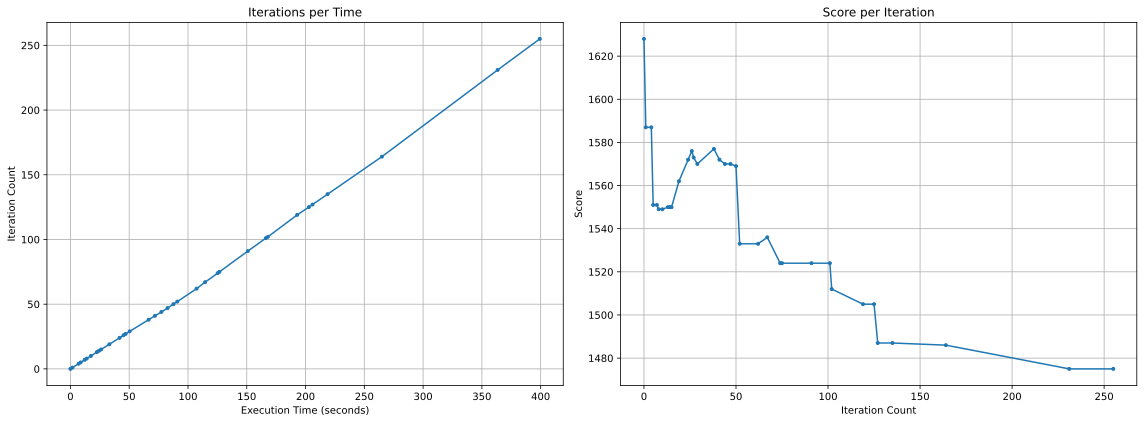

Circuit  on 8 qubits with 500 gates.
        45 is the T-count
        455 Cliffords among which
        158 2-qubit gates (158 CNOT, 0 other) and
        149 Hadamard gates.
Circuit  on 8 qubits with 307 gates.
        31 is the T-count
        276 Cliffords among which
        147 2-qubit gates (113 CNOT, 34 other) and
        67 Hadamard gates.


In [23]:
# 4. 新しいグラフ描画関数を呼び出す
print(get_gate_num(best_graph))
print("\n--- パフォーマンスグラフ ---")
plot_graphs2(score_history)

c = generate_H_S_CNOT_T_circuit(8, 500, p_t=0.08, seed=1001) # depthを少し小さくして実行時間を調整
print(c.stats())
c = pyzx.optimize.basic_optimization(c)
print(c.stats())